<a href="https://colab.research.google.com/github/Eduzc07/machinelearning/blob/master/10_Final_PneumoAI/AutomatedDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build an Automated Diagnosis Model

Install Kaggle.

In [0]:
!pip install -q kaggle

Download Kaggle Credentials.

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Download Datasets from Kaggle.

In [3]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:50<00:00, 27.2MB/s]
100% 2.29G/2.29G [00:51<00:00, 48.2MB/s]
CPU times: user 419 ms, sys: 80.7 ms, total: 500 ms
Wall time: 53.9 s


Unzip the Data.

In [0]:
from zipfile import ZipFile
with ZipFile("./chest-xray-pneumonia.zip", "r") as f:
    f.extractall(path = "./")

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau

import keras
import random

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

%matplotlib inline

## Data Preparation

In [0]:
#Create variables from the fix Directories
train_dir = "./chest_xray/train/"
valid_dir = "./chest_xray/val/"
test_dir = "./chest_xray/test/"

### Data augmentation 

In [34]:
batch_size = 192

#Create training data generator
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1) #Create image generator in the abstract

train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size = (150, 150), #what size image we want
        batch_size = batch_size, #how many files to read in at a time
        class_mode = "categorical")

#Create validation test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (150, 150),
        batch_size = 1,
        class_mode = "categorical",
        shuffle = False)

#Create validation data generator
val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = "categorical")

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Display Chest X-Ray Data

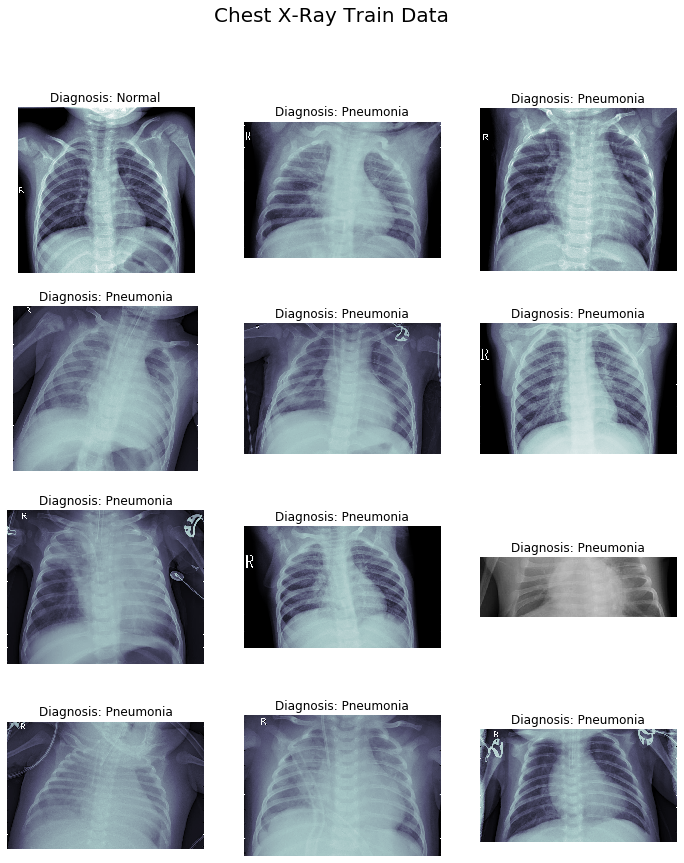

In [8]:
#Generate all predictions
filenames = train_generator.filenames
base_file = train_dir
nb_samples = len(filenames)

rows = 4
cols = 3
size_w = 4
size_h = 3.5

fig, ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle('Chest X-Ray Train Data', fontsize=20)

for idx in range(0, rows*cols):
    i = random.randint(0, nb_samples - 1)
    filename = base_file + filenames[i]

    actual = "Normal" if "NORMAL" in filename else "Pneumonia" 
    tittle = 'Diagnosis: {}'.format(actual)

    img = mpimg.imread(filename)

    ax[idx//cols,idx%cols].imshow(img, cmap='bone')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(tittle)

plt.show()

## Train Model

Create a model using as base InceptionV3.

In [0]:
# base_model = InceptionV3(weights = 'imagenet', include_top = False)
# #base_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150))

# base_model.trainable = False  # Freeze the layers not to train

# # final_model = Sequential([base_model,
# #                           GlobalAveragePooling2D(),
# #                           Dense(1024, activation = 'relu'),
# #                           Dropout(rate = 0.3),
# #                           Dense(512, activation = 'relu'),
# #                           Dropout(rate = 0.3),
# #                           Dense(256, activation = 'relu'),
# #                           Dropout(rate = 0.3),
# #                           Dense(128, activation = "relu"),
# #                           Dropout(rate = 0.3),
# #                           Dense(64, activation = "relu"),
# #                           Dropout(rate = 0.3),
# #                           BatchNormalization(),
# #                           Dense(2, activation = "softmax")])

# final_model = Sequential([base_model,
#                           Dropout(rate = 0.5),
#                           GlobalAveragePooling2D(),
#                           Dense(128, activation = "relu"),
#                           BatchNormalization(),
#                           Dense(2, activation = "sigmoid")])

# final_model.compile(optimizer = 'adam',
#                     loss = 'categorical_crossentropy',
#                     metrics = ['accuracy'])

# final_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 150, 150, 256)     1024      
_________________________________________________________________
dropout_16 (Dropout)         (None, 150, 150, 256)     0         
_________________________________________________________________
dense_22 (Dense)             (None, 150, 150, 128)     32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 150, 150, 128)     0         
_________________________________________________________________
dense_23 (Dense)             (None, 150, 150, 64)      8256      
_________________________________________________________________
dropout_18 (Dropout)         (None, 150, 150, 64)      0         
_________________________________________________________________
dense_24 (Dense)             (None, 150, 150, 32)     

Create Model using CNN.

In [42]:
image_height = 150
image_width = 150

final_model = Sequential()
final_model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width, 3),activation='relu'))
final_model.add(Conv2D(32,(3,3),activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))
final_model.add(Dropout(rate = 0.8))
final_model.add(Conv2D(64,(3,3),activation='relu'))
final_model.add(Conv2D(64,(3,3),activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))
final_model.add(Dropout(rate = 0.8))
final_model.add(Conv2D(128,(3,3),activation='relu'))
final_model.add(Conv2D(128,(3,3),activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2,2)))
final_model.add(Dropout(rate = 0.8))
final_model.add(Flatten())
final_model.add(Dense(units=128,activation='relu'))
final_model.add(Dropout(rate = 0.8))
final_model.add(Dense(units=2, activation='sigmoid'))

final_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

final_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 34, 34, 64)       

In [43]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch = len(train_generator),
        epochs = 20,
        validation_data = val_generator, #validation data generator 
        validation_steps = len(val_generator))

Epoch 1/20
28/28 [==============================] - 88s 3s/step - loss: 0.6475 - acc: 0.7283 - val_loss: 0.7118 - val_acc: 0.5000
Epoch 2/20
28/28 [==============================] - 87s 3s/step - loss: 0.5860 - acc: 0.7445 - val_loss: 0.7299 - val_acc: 0.5000
Epoch 3/20
28/28 [==============================] - 87s 3s/step - loss: 0.5765 - acc: 0.7401 - val_loss: 0.7055 - val_acc: 0.5000
Epoch 4/20
28/28 [==============================] - 87s 3s/step - loss: 0.5567 - acc: 0.7429 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 5/20
28/28 [==============================] - 87s 3s/step - loss: 0.5101 - acc: 0.7434 - val_loss: 0.6813 - val_acc: 0.5000
Epoch 6/20
28/28 [==============================] - 87s 3s/step - loss: 0.4736 - acc: 0.7443 - val_loss: 0.6816 - val_acc: 0.5000
Epoch 7/20
28/28 [==============================] - 86s 3s/step - loss: 0.4705 - acc: 0.7449 - val_loss: 0.6756 - val_acc: 0.5000
Epoch 8/20
28/28 [==============================] - 86s 3s/step - loss: 0.4509 - acc: 0.74

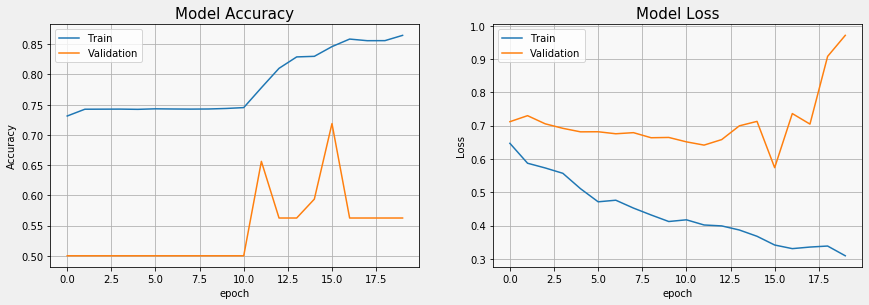

In [44]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10 == 1: # set up the subplots on the first call
    plt.subplots(figsize=(12, 8), facecolor='#F0F0F0')
    plt.tight_layout()

  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model ' + title, fontsize = 15)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['Train', 'Validation'])
  ax.grid(True)

display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'Accuracy', 221)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'Loss', 222)

In [45]:
result = final_model.evaluate_generator(test_generator,
                                         steps = len(test_generator))
print('Loss: %.2f'% result[0])
print('Accuracy: %.3f %%'% (result[1]*100))

Loss: 0.53
Accuracy: 73.558 %


In [46]:
vl_score = final_model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.96      0.30      0.46       234
   Pneumonia       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.83      0.65      0.64       624
weighted avg       0.80      0.73      0.69       624

AUC:  0.6478632478632479


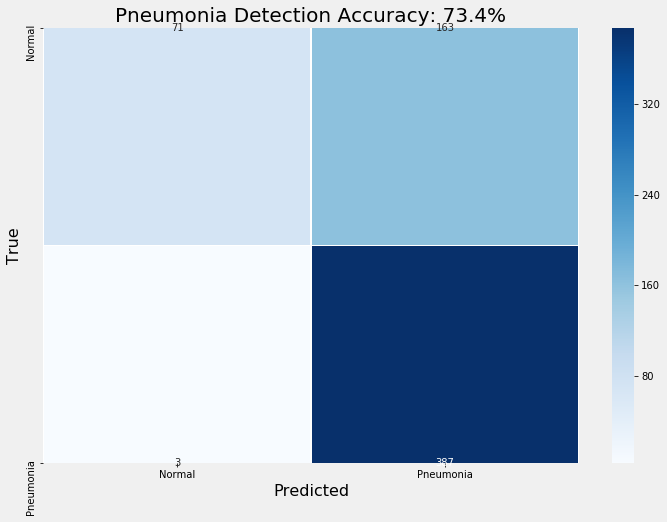

In [47]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

#plt.figure(figsize=(12, 8), facecolor='#F0F0F0')
fig, ax = plt.subplots(1,1, figsize=(12, 8), facecolor='#F0F0F0')

sns.heatmap(cm_df, cmap='Blues', annot=True, fmt='g', linewidths=.5)

plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc), fontsize = 20)
plt.ylabel('True', fontsize = 16)
plt.xlabel('Predicted', fontsize = 16)
plt.show()

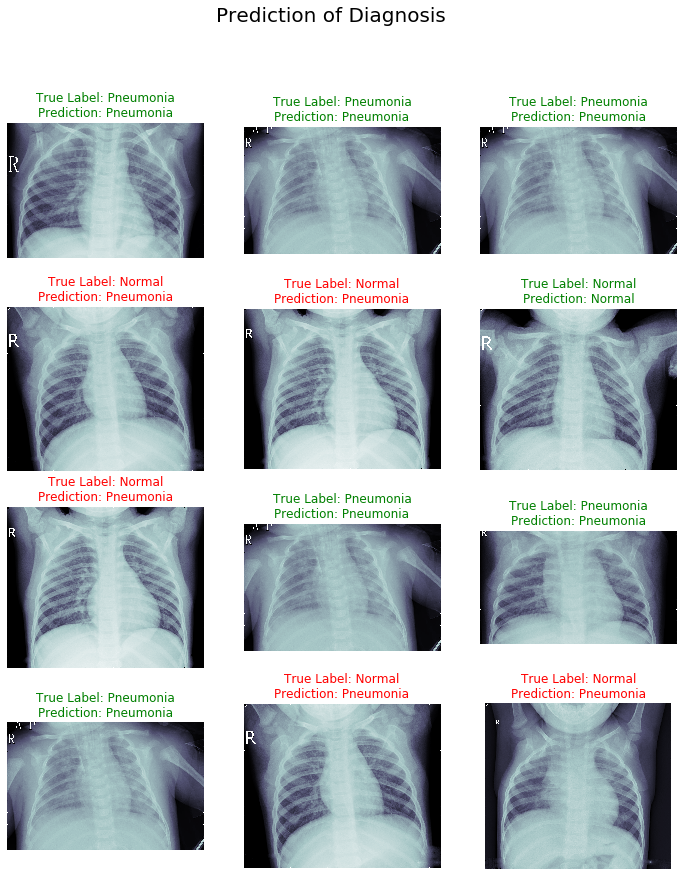

In [40]:
#Generate predictions from Validation Sets
filenames = val_generator.filenames
base_file = valid_dir
nb_samples = len(filenames)

label_CM = {0: 'red',  # Incorrect diagnosis
            1: 'green' # Correct diagnosis
            }

rows = 4
cols = 3
size_w = 4
size_h = 3.5

fig, ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle('Prediction of Diagnosis', fontsize = 20)

for idx in range(0, rows*cols):
    i = random.randint(0, nb_samples - 1)
    filename = base_file + filenames[i]
    
    img = image.load_img(filename, target_size=(150, 150, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    #x = preprocess_input(x)

    # Run Prediction
    y = final_model.predict(x)

    actual = "Normal" if "NORMAL" in filename else "Pneumonia" 
    predicton = "Normal" if (y.argmax(axis=-1)==0) else "Pneumonia"
    score = 1 if (actual == predicton) else 0

    title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))

    img = mpimg.imread(filename)

    ax[idx//cols,idx%cols].imshow(img, cmap='bone')
    # extent = 0, 1, 0, 1
    # ax[idx//cols,idx%cols].imshow(im_data, cmap='gray_r', extent=extent)
    # ax[idx//cols,idx%cols].imshow(attn_img, cmap='magma', vmin=0, vmax=1,
    #                               extent=extent, alpha=0.5,
    #                               interpolation='lanczos')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(title_text, color=label_CM[score])

plt.show()

## Sources

[1] [Pneumonia_detection_multi_vgg](https://github.com/iRyanBell/chest_xray_pneumonia_vgg_attn_ensemble/blob/master/pneumonia_detection_multi_vgg.ipynb)

[2] [Transfer_Learning_Xray_Pneumonia](https://github.com/mannybernabe/transferLearning_pneumonia/blob/master/Transfer_Learning_Xray_Pneumonia.ipynb)

[3] [Detection of Pneumonia](https://colab.research.google.com/gist/JayThibs/73a58e51326f1fb548b09df94166a3ca/detection-of-pneumonia-from-chest-x-ray-images-1-0-0-0.ipynb#scrollTo=-aGOUzQM88Ci)

In [48]:
model_json = final_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
final_model.save_weights("model_weight.h5")
print("Saved model to disk")

Saved model to disk
